# Part 0:
# **Importing Required Libraries and Setup**

In [2]:
import pandas as pd
import numpy as np
import os 
import cv2
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install mxnet
# !pip install gluoncv
from gluoncv import model_zoo, data, utils
from scipy import stats

import warnings # To prevent warnings of future changes
warnings.filterwarnings('ignore')

# Part 0:
# **Loading Data (Images ID + Counts)**

In [3]:
def read_csv_images(csv_path):
    """Reads the 'images' and 'counts' fields of the table in the CSV file from the provided 'path',
    also the images themselves.
    """    
    df = pd.read_csv(csv_path)
    if 'counts' not in df: # creating a new column of zeroes to the dataframe as 'counts', if it is not there
        df['counts'] = 0
    return list(df['images']), list(df['counts'])

root = '../input/vehiclecounting'
rootSave = '../working'
images_path = os.path.join(root, "TRANCOS", "TRANCOS") 
csv_names = {"Training set  ": "train_count.csv", 
             "Validation set": "valid_count.csv",
             "Test set      ": "test.csv"
            }
labeled_subsets = list(csv_names.keys())[0 : 2] 
imagesNames_counts = {}
for spec, csv_path in  csv_names.items():
    imagesNames_counts[spec] = read_csv_images(os.path.join(root, csv_path))
    print(spec, 'size:', np.shape(imagesNames_counts[spec][1])[0])

Training set   size: 623
Validation set size: 200
Test set       size: 421


# Part 0:
# **Sample Image and Related RGB Histogram**

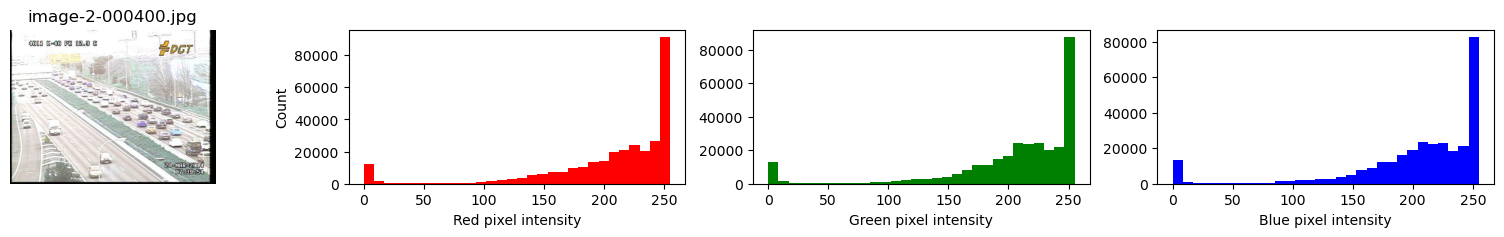

In [4]:
def plotRGBHistogram(image_path, imageName):
    """
    Plot histogram of RGB Pixel Intensities (https://www.kaggle.com/hamishdickson/transfer-learning-vs-fine-tuning/notebook)
    """
    image = cv2.imread(os.path.join(image_path, imageName))
    plt.figure(figsize=(20,2))
    plt.subplot(1,4,1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(imageName)
    histo = plt.subplot(1,4,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Red pixel intensity')
    n_bins = 30
    plt.hist(image[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=1);
    histo = plt.subplot(1,4,3)
    histo.set_xlabel('Green pixel intensity')
    plt.hist(image[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=1);
    histo = plt.subplot(1,4,4)
    histo.set_xlabel('Blue pixel intensity')
    plt.hist(image[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=1);

plotRGBHistogram(images_path, imagesNames_counts["Training set  "][0][0])

# Part 0:
# **Training and Validation Subsets Distribution Visualization (Violin Plot)**

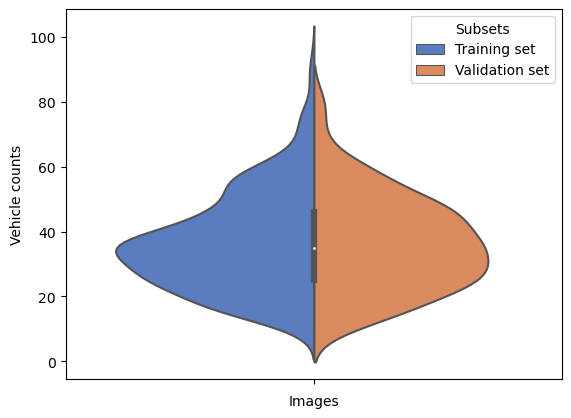

In [5]:
violinplotData = pd.DataFrame({"Vehicle counts":[imagesNames_counts["Training set  "][1] + imagesNames_counts["Validation set"][1]][0], 
             "Subsets": ["Training set  "] * np.shape(imagesNames_counts["Training set  "][1])[0] +
                    ["Validation set"] * np.shape(imagesNames_counts["Validation set"][1])[0]})
violinplotData["Images"] = ''
ax = sns.violinplot(x="Images", y="Vehicle counts", hue= "Subsets", data=violinplotData, split=True, palette="muted")

# Part 1:
# **Vehicle Count Estimation using Pre-trained Network Models (RCNN, YOLO)**
* https://cv.gluon.ai/build/examples_detection/demo_faster_rcnn.html
* https://softwaremill.com/counting-objects-with-faster-rcnn/
* https://towardsdatascience.com/4-pre-trained-cnn-models-to-use-for-computer-vision-with-transfer-learning-885cb1b2dfc
* https://www.kaggle.com/pavansanagapati/simple-tutorial-on-object-recognition
* https://www.kaggle.com/mineshjethva/pretrained-object-detection-models
* https://github.com/taehoonlee/tensornets
* [Vehicle Detection Using Deep Learning and YOLO Algorithm](https://pythonrepo.com/repo/MaryamBoneh-Vehicle-Detection)

In [9]:
# NB: No duplicate detection. No 'short=512' argument for YOLO. 11:20
models = {#"yolo": ('yolo', "yolo3_darknet53_coco"),
          #"rcnn_1": ('rcnn', "mask_rcnn_resnet50_v1b_coco"), # GPU P100; 1min/image; 200min in total
          "rcnn_3": ('rcnn', "faster_rcnn_resnet50_v1b_coco"),
          "rcnn_2": ('rcnn', "mask_rcnn_resnet101_v1d_coco"),           
          "rcnn_4": ('rcnn', "faster_rcnn_resnet101_v1d_coco")}
score_thr = 50/100
count_est = {}
for modelKey, modelVal in models.items(): # Loops through net models
  net = model_zoo.get_model(modelVal[1], pretrained=True)
  car_idx = net.classes.index("car") # Finds the index of the category "car"
  count_est[modelVal[1]] = {}
  for subset_type in csv_names.keys(): # Loops through the subsets (Training/Validation/Test)
    if subset_type.strip().lower() in ["validation set"]: # , "test set" Only do for the validation and test subsets
    # if (modelKey == 'rcnn_3' and subset_type.strip().lower() == "validation set"): #or (modelKey != 'rcnn_1' and subset_type.strip().lower() in ["validation set", "test set"]) : 
      count_est[modelVal[1]][subset_type] = []
      for image_pathIdx, image_path in enumerate(imagesNames_counts[subset_type][0][:]): # Loops through images
        exec('x, orig_img = data.transforms.presets.' + modelVal[0] +'.load_test(os.path.join(images_path, image_path))') 
        if modelKey in ['rcnn_1', 'rcnn_2']:
            box_ids, scores, bboxes, masks = net(x)
        elif modelKey in ['yolo', 'rcnn_3', 'rcnn_4']:
            box_ids, scores, bboxes = net(x)
        count_est[modelVal[1]][subset_type].append(np.shape([score[0] for box_id, score in zip(box_ids[0].asnumpy(), scores[0].asnumpy()) if (box_id == car_idx and score >= score_thr)])[0])
        # count_est[modelVal[1]][subset_type].append(imagesNames_counts[subset_type][1][image_pathIdx] + np.random.randint(10)) # Dommy scenario *************************
        print(image_pathIdx, "/", len(imagesNames_counts[subset_type][0][:]),"-", modelVal[1], "/", subset_type.strip(), "("+image_path[:-4]+")", "/", "Estim. count:", count_est[modelVal[1]][subset_type][image_pathIdx], "/", "True count:", imagesNames_counts[subset_type][1][image_pathIdx])    
      pd.DataFrame({'estimation': count_est[modelVal[1]][subset_type]}).to_csv(os.path.join(rootSave, 'submission_'+subset_type.strip()+'_'+modelKey+'.csv'), index=False) # Saves the submission DF to CSV

0 / 200
1 / 200
2 / 200
3 / 200
4 / 200
5 / 200
6 / 200
7 / 200
8 / 200
9 / 200
10 / 200
11 / 200
12 / 200
13 / 200
14 / 200
15 / 200
16 / 200
17 / 200
18 / 200
19 / 200
20 / 200
21 / 200
22 / 200
23 / 200
24 / 200
25 / 200
26 / 200
27 / 200
28 / 200
29 / 200
30 / 200
31 / 200
32 / 200
33 / 200
34 / 200
35 / 200
36 / 200
37 / 200
38 / 200
39 / 200
40 / 200
41 / 200
42 / 200
43 / 200
44 / 200
45 / 200
46 / 200
47 / 200
48 / 200
49 / 200
50 / 200
51 / 200
52 / 200
53 / 200
54 / 200
55 / 200
56 / 200
57 / 200
58 / 200
59 / 200
60 / 200
61 / 200
62 / 200
63 / 200
64 / 200
65 / 200
66 / 200
67 / 200
68 / 200
69 / 200
70 / 200
71 / 200
72 / 200
73 / 200
74 / 200
75 / 200
76 / 200
77 / 200
78 / 200
79 / 200
80 / 200
81 / 200
82 / 200
83 / 200
84 / 200
85 / 200
86 / 200
87 / 200
88 / 200
89 / 200
90 / 200
91 / 200
92 / 200
93 / 200
94 / 200
95 / 200
96 / 200
97 / 200
98 / 200
99 / 200
100 / 200
101 / 200
102 / 200
103 / 200
104 / 200
105 / 200
106 / 200
107 / 200
108 / 200
109 / 200
110 / 200


200326KB [00:06, 31224.42KB/s]                            


0 / 200
1 / 200
2 / 200
3 / 200
4 / 200
5 / 200
6 / 200
7 / 200
8 / 200
9 / 200
10 / 200
11 / 200
12 / 200
13 / 200
14 / 200
15 / 200
16 / 200
17 / 200
18 / 200
19 / 200
20 / 200
21 / 200
22 / 200
23 / 200
24 / 200
25 / 200
26 / 200
27 / 200
28 / 200
29 / 200
30 / 200
31 / 200
32 / 200
33 / 200
34 / 200
35 / 200
36 / 200
37 / 200
38 / 200
39 / 200
40 / 200
41 / 200
42 / 200
43 / 200
44 / 200
45 / 200
46 / 200
47 / 200
48 / 200
49 / 200
50 / 200
51 / 200
52 / 200
53 / 200
54 / 200
55 / 200
56 / 200
57 / 200
58 / 200
59 / 200
60 / 200
61 / 200
62 / 200
63 / 200
64 / 200
65 / 200
66 / 200
67 / 200
68 / 200
69 / 200
70 / 200
71 / 200
72 / 200
73 / 200
74 / 200
75 / 200
76 / 200
77 / 200
78 / 200
79 / 200
80 / 200
81 / 200
82 / 200
83 / 200
84 / 200
85 / 200
86 / 200
87 / 200
88 / 200
89 / 200
90 / 200
91 / 200
92 / 200
93 / 200
94 / 200
95 / 200
96 / 200
97 / 200
98 / 200
99 / 200
100 / 200
101 / 200
102 / 200
103 / 200
104 / 200
105 / 200
106 / 200
107 / 200
108 / 200
109 / 200
110 / 200


100%|██████████| 192537/192537 [00:05<00:00, 34280.29KB/s]


0 / 200
1 / 200
2 / 200
3 / 200
4 / 200
5 / 200
6 / 200
7 / 200
8 / 200
9 / 200
10 / 200
11 / 200
12 / 200
13 / 200
14 / 200
15 / 200
16 / 200
17 / 200
18 / 200
19 / 200
20 / 200
21 / 200
22 / 200
23 / 200
24 / 200
25 / 200
26 / 200
27 / 200
28 / 200
29 / 200
30 / 200
31 / 200
32 / 200
33 / 200
34 / 200
35 / 200
36 / 200
37 / 200
38 / 200
39 / 200
40 / 200
41 / 200
42 / 200
43 / 200
44 / 200
45 / 200
46 / 200
47 / 200
48 / 200
49 / 200
50 / 200
51 / 200
52 / 200
53 / 200
54 / 200
55 / 200
56 / 200
57 / 200
58 / 200
59 / 200
60 / 200
61 / 200
62 / 200
63 / 200
64 / 200
65 / 200
66 / 200
67 / 200
68 / 200
69 / 200
70 / 200
71 / 200
72 / 200
73 / 200
74 / 200
75 / 200
76 / 200
77 / 200
78 / 200
79 / 200
80 / 200
81 / 200
82 / 200
83 / 200
84 / 200
85 / 200
86 / 200
87 / 200
88 / 200
89 / 200
90 / 200
91 / 200
92 / 200
93 / 200
94 / 200
95 / 200
96 / 200
97 / 200
98 / 200
99 / 200
100 / 200
101 / 200
102 / 200
103 / 200
104 / 200
105 / 200
106 / 200
107 / 200
108 / 200
109 / 200
110 / 200


# Part 1:
# **Evaluation metrics (MDE, MAE, ...) for Estimates of Pre-trained Network Models (RCNN, YOLO) on Training and Validation subsets**

In [ ]:
fig = plt.figure(figsize=(5*len(models), 5)) # , sharex=True, sharey=True 1, len(models),  , squeeze=False
# fig.suptitle('Evaluation metrics per network models and subsets', fontsize=20, fontweight='bold')
# fig.add_subplot(111, frameon=False) # add a big axis, hide frame
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False) # hide tick and tick label of the big axis
# plt.xlabel("True counts", fontweight='bold')
# plt.ylabel("\bPredicted counts\n") # , fontweight='bold'
count_err = {}
for modelNb, modelVal in enumerate(count_est.keys()): # Loops through net models  count_est[modelVal]
  # modelVal = modelVal[1]
  count_err[modelVal] = {}
  for subset_typeNb, subset_type in enumerate(count_est[modelVal]): # Loops through the labeled subsets (Training/Validation)
    if "validation" in subset_type.lower(): # Only do for the validation subset
      count_err[modelVal][subset_type] = {}
      y = np.asarray(count_est[modelVal][subset_type]) # Predicted counts
      X = np.asarray(imagesNames_counts[subset_type][1][:]) # True counts
      err = y - X
      # print(len(X))
      # print(len(y))
      count_err[modelVal][subset_type]['MAE'] = np.mean(np.abs(err))
      count_err[modelVal][subset_type]['MSE'] = np.mean(np.abs(err) ** 2)
      count_err[modelVal][subset_type]['MDE'] = np.mean(np.abs(err) / X)
      pearson_coef, p_value = stats.pearsonr(X, y)
      count_err[modelVal][subset_type]['PearsonCC'] = pearson_coef
      count_err[modelVal][subset_type]['P-value'] = p_value
      data = pd.DataFrame({"True": X, "Pred": y})
      # axs[modelNb, subset_typeNb].grid(True)
      # axs[modelNb].grid(True)
      # if modelNb == 0: # subset_typeNb == 0 and 
      ax = plt.subplot(1, len(models), modelNb + 1)
      ax.grid(True)
      ax.set_ylim([0, 100]) # , subset_typeNb axs[1, modelNb]
      ax.set_xlim([0, 100]) # , subset_typeNb
      # ax = plt.subplot(1, len(models), modelNb + 1)
      regplot = sns.regplot(ax=ax, x = "True", y = "Pred", data = data, line_kws={"color": "red"}) # , subset_typeNb
      # if subset_typeNb == 0:
      #     axs[modelNb, subset_typeNb].set_ylabel(modelVal)
      # if modelNb == 0:
      regplot.set_ylabel(modelVal)
      regplot.set_xlabel('')
      # regplot.set_ylabel(modelVal) # , subset_typeNb
      regplot.set_title(#subset_type +'\n'+ , subset_typeNb
                                            "MAE:{:.2f}, ".format(count_err[modelVal][subset_type]['MAE']) +
                                            "MSE:{:.2f}, ".format(count_err[modelVal][subset_type]['MSE']) +
                                            "MDE:{:.2f}".format(count_err[modelVal][subset_type]['MDE']) +
                                            '\n' +
                                            "Pearson's CC:{:.2f}, ".format(count_err[modelVal][subset_type]['PearsonCC']) +    
                                            "p-value:{:.2e}".format(count_err[modelVal][subset_type]['P-value'])) # Two-tailed 
      # else:
      #     axs[modelNb, subset_typeNb].set_title("MAE:{:.2f}, ".format(count_err[modelVal][subset_type]['MAE']) +
      #                                           "MSE:{:.2f}, ".format(count_err[modelVal][subset_type]['MSE']) +
      #                                           "MDE:{:.2f}".format(count_err[modelVal][subset_type]['MDE']) +
      #                                           '\n' +
      #                                           "Pearson's CC:{:.2f}, ".format(count_err[modelVal][subset_type]['PearsonCC']) +    
      #                                           "Two-tailed p-value:{:.2e}".format(count_err[modelVal][subset_type]['P-value']))   
# fig.suptitle('Evaluation metrics per network models and subsets', fontsize=20, fontweight='bold')
fig.add_subplot(111, frameon=False) # add a big axis, hide frame
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False) # hide tick and tick label of the big axis
plt.xlabel("\nTrue counts", fontweight='bold')
plt.ylabel("Predicted counts\n\n", fontweight='bold') # 
# for ax in axs.flat:
#     ax.set(xlabel='') 
# for ax in axs.flat: # Hide x labels and tick labels for top plots and y ticks for right plots.
#     ax.label_outer()
plt.show()

<!-- # Part 1:
# **Estimates Distribution (Box Plot) of Pre-trained Network Models (RCNN, YOLO) on Test subsets (Compared with those of Training/Validation)** -->

In [ ]:
boxplotData = []
boxplotLabel = []
# for subset_type in labeled_subsets: # Loops through the labeled subsets (Training/Validation)
#   if "test" in subset_type.lower(): # Only do for the validation subset
#     boxplotData.append(imagesNames_counts[subset_type][1])
#     boxplotLabel.append(subset_type.strip())
for modelKeys in count_est.keys(): # Loops through net models
  boxplotData.append(count_est[modelKeys]["Test set      "])
  boxplotLabel.append(modelKeys)
# np.shape(boxplotData)
fig = plt.figure() 
ax = fig.add_axes([0, 0, 1, 1]) # Creating axes instance
ax.boxplot(boxplotData) # Creating plot
ax.set_xticklabels(boxplotLabel, rotation=30)
ax.set_ylabel("Counts", fontweight='bold')
ax.set_xlabel("Estimators", fontweight='bold')
plt.title("Estimated counts distribution", fontsize=15, fontweight='bold') # Adding title
plt.show() # show plot


# Part 2:
# **Implementation of VGG with Different Configurations (VGG11/13/16/19-bn) introduced in *''Very Deep Convolutional Networks for Large-Scale Image Recognition''* by Simonyan et al.**
* https://paperswithcode.com/method/vgg
* https://github.com/pytorch/vision/blob/6db1569c89094cf23f3bc41f79275c45e9fcb3f3/torchvision/models/vgg.py

# Part 2:
# **Keras-based VGG16 Network Model (a Single Neuron Output Layer + L2 Loss) Trained from Scratch**
https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing import image
from keras.models import load_model

In [ ]:
# Needs to be done only once: Separates the directory containing the whole images into Training, Validation, and Test directories
# from shutil import copy
# for subset_type in csv_names.keys(): # Loops through the subsets (Training/Validation/Test)
#   dst = os.path.join(root, "TRANCOS", subset_type)
#   if not os.path.exists(dst): # Create the subset paths if they don't exist
#     os.makedirs(dst)
#   for imageName in imagesNames_counts[subset_type][0]:
#     src = os.path.join(images_path, imageName)
#     copy(src, dst)

In [ ]:
# Data formatting
img_width, img_height = (224, 224)
imageData = {}
for subset_type, csv_path in csv_names.items(): # Loops through the subsets (Training/Validation/Test)
  label_df = pd.read_csv(os.path.join(root, csv_path), skiprows=1, names=['id', 'score'])
  label_df = label_df.astype({"score": np.float32})
  subsetData = ImageDataGenerator()  
  imageData[subset_type] = subsetData.flow_from_dataframe(dataframe=label_df, directory=images_path, 
                                                          x_col="id", y_col="score", has_ext=True,
                                                          class_mode="other", target_size=(img_width, img_height)) # batch_size= 1000 https://stackoverflow.com/questions/41749398/using-keras-imagedatagenerator-in-a-regression-model                                          

In [ ]:
# Model building
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))

# A single neuron output layer with Relu activation function
# relu (Rectified Linear Unit) activation so that all the negative values are not returned in the output
model.add(Dense(units=1, activation="relu")) 

In [ ]:
# Model compiling with L2 loss (Ridge regression)
def L2_loss(y_true, y_pred):
  """ Computes the L2 norm of the error""" 
  return tf.nn.l2_loss(y_true - y_pred) 

model.compile(loss = L2_loss,  # <-------- Here the L2 loss (Ridge regression) is defined (https://stackoverflow.com/questions/58556857/implementing-an-l2-loss-into-a-tensorflow-sequential-regression-model)
              optimizer=Adam(lr=0.001), metrics=['mse'])
model.summary()

In [ ]:
# ModelCheckpoint and EarlyStopping method importiing from keras
VGG16CheckpointName = os.path.join(root, 'Models', "vgg16_Scratch.h5")
checkpoint = ModelCheckpoint(VGG16CheckpointName, monitor='val_mse', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=5)
early = EarlyStopping(monitor='val_mse', min_delta=0, patience=20, verbose=1, mode='auto')

In [ ]:
# Model fitting (training)
hist = model.fit_generator(steps_per_epoch=10,generator=imageData["Training set  "], 
                           validation_data= imageData["Validation set"], validation_steps=10,
                           epochs=100,callbacks=[checkpoint,early])

In [ ]:
# Visualising training/validation mse and loss over training epochs
plt.plot(hist.history["mse"][1:])
plt.plot(hist.history['val_mse'][1:])
plt.plot(hist.history['loss'][1:])
plt.plot(hist.history['val_loss'][1:])
plt.title("Model Performance", fontsize=15, fontweight='bold')
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.legend(["MSE","Validation MSE","loss","Validation Loss"])
plt.show()

In [ ]:
# Predictions on the test subset
# saved_model = load_model(VGG16CheckpointName)
saved_model = model
testVGG16 = []
for image_pathIdx, image_path in enumerate(imagesNames_counts["Test set      "][0]): # Loops through test subset
  img = image.load_img(os.path.join(images_path, image_path), target_size= (img_width, img_height))
  img = np.asarray(img)
  img = np.expand_dims(img, axis=0)
  output = saved_model.predict(img)
  testVGG16.append(output[0][0])
testVGG16 = pd.DataFrame({"VGG16_Scratch": testVGG16})

In [ ]:
plt.plot(testVGG16)
plt.title("Vehicle Counts Estimates on Test Subset", fontsize=15, fontweight='bold')
plt.ylabel("Predicted")
plt.xlabel("Samples")
plt.show()

# Part 2 (Pre-trained):
# **Keras-based Modified Pre-trained VGG16 Network Model (Output Layer Replaced with a Single Neuron) Fine-tuned (L2 Loss) Only for the Newly-replaced Output Layer on the TRANCOS Dataset**
* https://www.pyimagesearch.com/2020/10/05/object-detection-bounding-box-regression-with-keras-tensorflow-and-deep-learning/
* https://stackoverflow.com/questions/58556857/implementing-an-l2-loss-into-a-tensorflow-sequential-regression-model
* https://stackoverflow.com/questions/46036522/defining-model-in-keras-include-top-true
* https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
* https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
* https://keras.io/api/preprocessing/image/
* https://medium.com/@1297rohit/transfer-learning-from-scratch-using-keras-339834b153b9
* https://keras.io/api/losses/
* https://github.com/taehoonlee/tensornets-examples/blob/master/test_all_voc_models.ipynb
* https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751
* https://www.kaggle.com/mtax687/l2-regularization-of-neural-network-using-numpy
* https://www.kaggle.com/sid321axn/regularization-techniques-in-deep-learning#Implementation-on-Malaria-Cell-Identification-with-keras
* https://www.kaggle.com/souravkgoyal/fine-tuning-pretrained-model-keras
* https://www.kaggle.com/hamishdickson/transfer-learning-vs-fine-tuning/notebook

# Part 2 (Pre-trained):
# **Importing Required Libraries**

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input, Dense

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

# import torch

# Part 2 (Pre-trained):
# **Defining Required Functions**

In [ ]:
def L2_loss(y_true, y_pred):
  """ Computes the L2 norm of the error
  Inputs: 
    y_true: True vehicle count
    y_pred: Estimated vehicle count

  Output:
    L2-norm of the error (y_true - y_pred)
  """ 
  return tf.nn.l2_loss(y_true - y_pred)  # np.linalg.norm(y_true - y_pred)


def pretrained_VGG16_singleNeuronOutput_L2Loss(img_shape, ):
  """ Initializes a pre-trained (imagenet) VGG16 model, removes the last layer, 
  adds a singl-neuron layer, creates the model, initialises the optimizer, 
  and compiles the model with L2 loss (Ridge regression)
  Input: 
    img_shape: A tuple containing image width, height, and depth
  Output:
    vgg16_preTrainedModel: The modified pre-trained VGG16 model
  """

  vgg16 = VGG16(weights='imagenet', include_top=True, input_tensor=Input(shape=img_shape)) # Loads the VGG16 network with pretrained weights (imagenet), ensuring the head FC layers are included
  vgg16.trainable = False # Freezes all VGG layers so they will *not* be updated during the training process
  vgg16_out = vgg16.layers[-2].output # Removes the classifier output layer, i.e., the second last FC layer with 4,096 nodes will be the new output layer
  outputs = Dense(1, activation='relu', name='counts_estimation')(vgg16_out) # Adds a single-neuron Dense layer where input is the output of the  second last layer of the original VGG16
  vgg16_preTrainedModel = Model(inputs=vgg16.input, outputs=outputs) # Creates the corresponding model 
  # vgg16_preTrainedModel = vgg16_preTrainedModel.to(device=device) #to send the model for training on either cuda or cpu
  vgg16_preTrainedModel.compile(loss = 'mse',  # L2_loss <-------- Here the L2 loss (Ridge regression) is defined (https://stackoverflow.com/questions/58556857/implementing-an-l2-loss-into-a-tensorflow-sequential-regression-model)
                optimizer=Adam(lr=0.001), metrics=['mse']) # Model compiling with L2 loss (Ridge regression) (, decay=0.002)
  return vgg16_preTrainedModel


def plot_hist(H, countEst, savefigPath):
  """ Plots MSE and Loss for the training and validation subsets, besides the 
  estimated vehicle counts resulted from the model of the last epoch
  Inputs:
    H: Trained model
    countEst: Estimated vehicle counts resulted from the model of the last epoch 
    savefigPath: path to save the figure

  Outputs:
    Plots the figure, and save the plotted figure in the specified figure path
  """
  plt.figure(figsize=(10, 5))
  plt.subplot(1,2,1)
  plt.plot(H.history["mse"][0:])
  plt.plot(H.history['val_mse'][0:])
  plt.plot(H.history['loss'][0:])
  plt.plot(H.history['val_loss'][0:])
  plt.title("Model Performance", fontsize=10, fontweight='bold')
  plt.ylabel("MSE")
  plt.xlabel("Epoch")
  plt.legend(["MSE","Validation MSE","loss","Validation Loss"])

  plt.subplot(1,2,2)
  plt.plot(countEst)
  plt.title("Vehicle Counnts Estimates on Test Subset", fontsize=10, fontweight='bold')
  plt.ylabel("Predicted")
  plt.xlabel("Samples")
  fig1 = plt.gcf()
  plt.show()
  plt.draw()
  fig1.savefig(savefigPath)


def prepare_input(subset_types, imagesNames_counts, images_path, img_shape):
  """ Loads images for all subsets, converts to a numpy array, and normalises them between 0 and 1
  Inputs:
    subset_types: A list containing the name of the subsets, i.e., training/validation/test
    imagesNames_counts: A dictionary containing the name of the images, e.g., image-3-000335
    images_path: Path to the images
    img_shape: A tuple containing image width, and height
    
  Outputs:
    images: A dictionary containing the images for all subsets
    targets: A dictionary containing the counts of images for all subsets
    testImages: A list containing the test images
    """    
  images = {}
  targets = {}
  for subset_type in subset_types: # Loops through the subsets (Training/Validation/Test)
    images[subset_type] = []
    for image_pathIdx, image_path in enumerate(imagesNames_counts[subset_type][0][0:]): # Loops through images
      imagePath = os.path.join(images_path, image_path) # Path to each image from subsets
      image = load_img(imagePath, target_size=img_shape) # loads the input image (in Keras format) from disk    
      image = img_to_array(image) # converts the image pixels to a numpy array
      # reshape data for the model
      # image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
      # image = np.expand_dims(image, axis=0)
      # # prepare the image for the VGG model
      image = preprocess_input(image)
      images[subset_type].append(image)
      print(subset_type.strip(), "("+image_path[:-4]+")", end=', ') 
    images[subset_type] = np.array(images[subset_type], dtype="float32") / 255.0 # convert the image to NumPy arrays, scaling the input pixel intensities from the range [0, 255] to [0, 1]
    targets[subset_type] = np.array(imagesNames_counts[subset_type][1], dtype="float32") # convert the target to NumPy arrays

  # Predictions on the test subset
  testImages = []
  for image_pathIdx, image_path in enumerate(imagesNames_counts['Test set      '][0][0:]): # Loops through images
    imagePath = os.path.join(images_path, image_path) 
    image = load_img(imagePath, target_size=img_shape) # Loads an image from file
    image = img_to_array(image) / 255.0 # Converts the image pixels to a numpy array and normalises them
    image = np.expand_dims(image, axis=0) # Reshapes data for the model. Equivalent to: image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # image = preprocess_input(image) # prepare the image for the VGG model
    testImages.append(image)
    print("Test set ("+image_path[:-4]+")", end=', ') 
  # images['Training set  '] = images['Training set  '].to(device=device)
  # targets['Training set  '][0:] = targets['Training set  '][0:].to(device=device)
  # images['Validation set'] = images['Validation set'].to(device=device)
  # targets['Validation set'][0:] = targets['Validation set'][0:].to(device=device)
  return images, targets, testImages


def model_predict(imgs, model):
  """ Estimates the counts on the test set using the fine-tuned model, then 
  rounds them to the nearest integer
  Inputs:
    imgs: A list containing the images
    model: The trained model
    
  Output:
    outRound: The rounded predicted vehicle counts"""

  out = []
  for img in imgs: # Loops through test subset
    output = model.predict(img)
    out.append(output[0][0])
  outRound = round_int(out) # Rounds to the nearest integer the countinuos estimates
  return outRound


def round_int(Float):
  """ Rounds and converts to integer"""
  round_intVal = np.round(Float).astype(int)
  return round_intVal


def save_csv(imagesName, countEst, csvName):
  """ Saves the estimated counts as a proper CSV submission file
  Inputs:
    imagesName: A list containing the test set images names
    countEst: A list containing the estimated counts
    csvName: An end part of the CSV file name"""
  submission = pd.DataFrame({"images": imagesName, "counts": countEst}) # Creates the submission DF 
  submission.to_csv(os.path.join(root, 'Submissions', 'submission_'+csvName+'.csv'), index=False) # Saves the submission DF to CSV

# Part 2 (Pre-trained):
# **Instantiating/Loading the model**

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda
MODEL_PATH = os.path.join(root, 'Models', "vgg16_Pretrained.h5") # Path to the pre-trained VGG16 model
img_width, img_height, img_depth = (224, 224, 3) # Image dimensions

if not os.path.isfile(MODEL_PATH): # If no model has been already saved into the model path
  print('Loading a pre-trained VGG16 model.')   
  vgg16_preTrainedModel = pretrained_VGG16_singleNeuronOutput_L2Loss((img_width, img_height, img_depth), )  
else: # If a model has already been saved
  print('Loading the previously-trained model.')
  vgg16_preTrainedModel = keras.models.load_model(MODEL_PATH) # Loads the previously-trained model
vgg16_preTrainedModel.summary() # Shows the model summary

# Part 2 (Pre-trained):
# **Preparing the Input images (Loading, Casting to NP Array, Normalising, Dimension Expanding) for all Subsets**

In [ ]:
images, targets, testImages = prepare_input(csv_names.keys(), imagesNames_counts, images_path, (img_width, img_height))

# Part 2 (Pre-trained):
# **Fine-tuning the Modified Pre-trained VGG16 Network Model**

In [ ]:
start_submission_ver = 26 # The number of submission version to start
for i in range(start_submission_ver, 100):
  print('Iteration {}'.format(i))
  H = vgg16_preTrainedModel.fit( # Fine-tuning
    images['Training set  '], targets['Training set  '][0:],
    validation_data=(images['Validation set'], targets['Validation set'][0:]),
    batch_size= 30,
    epochs= 25) # verbose=1    
  vgg16_preTrainedModel.save(MODEL_PATH, save_format="h5") # Serialize the model to disk 
  testVGG16Round = model_predict(testImages, vgg16_preTrainedModel) # Predicts the test images
  plot_hist(H, testVGG16Round, os.path.join(root, 'Submissions', 'submission_{}.png'.format(i))) # Visualising training/validation mse and loss over training epochs
  save_csv(imagesNames_counts['Test set      '][0], testVGG16Round, '{}'.format(i))

# Part 2 (Pre-trained):
# **Estimation Ensemble Across Epochs**

In [ ]:
start_ver = 9 # Start submission version 
end_ver = 15 # End submission version 
est_all = []
for ver in range(start_ver, end_ver):
  csv_path = os.path.join(root, 'Submissions', 'submission_{}.csv'.format(ver))
  label_df = pd.read_csv(csv_path) 
  est_all.append(np.asarray(label_df.counts))
est_all = np.asarray(est_all)
testMean = round_int(np.mean(est_all, axis=0)) # Mean across epochs
testMedian = round_int(np.median(est_all, axis=0)) # Median across epochs
save_csv(imagesNames_counts['Test set      '][0], testMean, 'mean_{}_{}'.format(start_ver, end_ver))
save_csv(imagesNames_counts['Test set      '][0], testMedian, 'median_{}_{}'.format(start_ver, end_ver))

plt.figure(figsize=(20, 5))
plt.plot(np.transpose(est_all), color= np.asarray([93, 93, 93])/255) 
plt.plot(testMean, 'b', label= 'Mean')
plt.plot(testMedian, 'r', label= 'Median')
plt.legend()
plt.ylabel('Estimated counts', fontweight='bold')
plt.xlabel('Test images', fontweight='bold')
plt.title('Estimation Mean/Median Across Fine-tuning Epochs', fontsize=20, fontweight='bold')

In [ ]:
# from keras.applications.vgg16 import VGG16
# from keras.preprocessing import image
# from keras.applications.vgg16 import preprocess_input
# from keras.layers import Input, Flatten, Dense
# from keras.models import Model
# import numpy as np

# #Get back the convolutional part of a VGG network trained on ImageNet
# model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
# # model_vgg16_conv.summary()

# #Create your own input format (here 3x200x200)
# # input = Input(shape=(3,200,200),name = 'image_input')
# input = Input(shape=(224, 224, 3),name = 'image_input')
# #Use the generated model 
# output_vgg16_conv = model_vgg16_conv(input)

# #Add the fully-connected layers 
# x = Flatten(name='flatten')(output_vgg16_conv)
# x = Dense(4096, activation='relu', name='fc1')(x)
# x = Dense(4096, activation='relu', name='fc2')(x)
# x = Dense(1, activation='softmax', name='predictions')(x)

# #Create your own model 
# my_model = Model(input, x)

# #In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
# # my_model.summary()
# from keras.applications.vgg16 import VGG16
# from keras.preprocessing import image
# from keras.applications.vgg16 import preprocess_input
# from keras.layers import Input, Flatten, Dense
# from keras.models import Model
# import numpy as np

# vgg16 = VGG16(weights=None, include_top=True)

# #Add a layer where input is the output of the  second last layer 
# x = Dense(1, activation='softmax', name='predictions')(vgg16.layers[-2].output)
# inp=
# #Then create the corresponding model 
# my_model = Model(vgg16.input,x)
# # my_model.summary()
# testVGG16
# vgg16_preTrainedModel
range(4, 10)

https://gram.web.uah.es/data/datasets/trancos/index.html#sec_the_paper